In [1]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from urllib.request import urlopen

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class CFG:
    epochs = 20
    batch_size = 32
    classes = [
        "ApplyEyeMakeup", "ApplyLipstick", "Archery", "BabyCrawling", "BalanceBeam",
        "BandMarching", "BaseballPitch", "Basketball", "BasketballDunk", "BenchPress",
        "Biking", "Billiards", "BlowDryHair", "BlowingCandles", "BodyWeightSquats",
        "Bowling", "BoxingPunchingBag", "BoxingSpeedBag", "BreastStroke", "BrushingTeeth",
        "CleanAndJerk", "CliffDiving", "CricketBowling", "CricketShot", "CuttingInKitchen",
        "Diving", "Drumming", "Fencing", "FieldHockeyPenalty", "FloorGymnastics",
        "FrisbeeCatch", "FrontCrawl", "GolfSwing", "Haircut", "HammerThrow",
        "Hammering", "HandstandPushups", "HandstandWalking", "HeadMassage", "HighJump",
        "HorseRace", "HorseRiding", "HulaHoop", "IceDancing", "JavelinThrow",
        "JugglingBalls", "JumpingJack", "JumpRope", "Kayaking", "Knitting",
        "LongJump", "Lunges", "MilitaryParade", "Mixing", "MoppingFloor",
        "Nunchucks", "ParallelBars", "PizzaTossing", "PlayingCello", "PlayingDaf",
        "PlayingDhol", "PlayingFlute", "PlayingGuitar", "PlayingPiano", "PlayingSitar",
        "PlayingTabla", "PlayingViolin", "PoleVault", "PommelHorse", "PullUps",
        "Punch", "PushUps", "Rafting", "RockClimbingIndoor", "RopeClimbing",
        "Rowing", "SalsaSpin", "ShavingBeard", "Shotput", "SkateBoarding",
        "Skiing", "Skijet", "SkyDiving", "SoccerJuggling", "SoccerPenalty",
        "StillRings", "SumoWrestling", "Surfing", "Swing", "TableTennisShot",
        "TaiChi", "TennisSwing", "ThrowDiscus", "TrampolineJumping", "Typing",
        "UnevenBars", "VolleyballSpiking", "WalkingWithDog", "WallPushups", "WritingOnBoard",
        "YoYo"
    ]
    videos_per_class = 10

In [3]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size=(224,224), frame_step=15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))
  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, duration=0.1)

In [4]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [5]:
def save_model(model, filepath):
    model.save(filepath)

In [6]:
def classify_video_url(model, video_url, n_frames=10):
    # Download video from URL
    video = urlopen(video_url)
    with open('temp_video.avi', 'wb') as f:
        f.write(video.read())

    # Create frames from the downloaded video
    video_frames = frames_from_video_file('temp_video.avi', n_frames=n_frames)

    # Predict using the model
    predictions = model.predict(np.expand_dims(video_frames, axis=0))

    # Classify the video based on predictions
    predicted_class = np.argmax(predictions)
    predicted_class_name = CFG.classes[predicted_class]

    print(f"Predicted Class: {predicted_class_name}")
    return predicted_class_name

In [7]:
# Load UCF101 dataset
file_paths = []
targets = []
for i, cls in enumerate(CFG.classes):
    sub_file_paths = glob.glob(f"/kaggle/input/ucf101/UCF101/UCF-101/{cls}/**.avi")[:CFG.videos_per_class]
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)

In [8]:
# Create frames for a sample video
sample_video = frames_from_video_file(file_paths[0], n_frames=10)
print(sample_video.shape)
to_gif(sample_video)

(10, 224, 224, 3)


In [9]:
# Create features
features = []
for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames=10))
features = np.array(features)

  0%|          | 0/1010 [00:00<?, ?it/s]

In [10]:
# Split dataset
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42)

In [11]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(CFG.batch_size * 4).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [12]:
# Clean up memory
del train_features
del val_features
gc.collect()

18

In [13]:
# Display shape of a batch
for X, y in train_ds.take(1):
    print(X.shape, y.shape)

(32, 10, 224, 224, 3) (32,)


In [14]:
# Build model
net = tf.keras.applications.EfficientNetB0(include_top=False)
net.trainable = False

efficient_net_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(255.0),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(len(CFG.classes)),
    tf.keras.layers.GlobalAveragePooling3D()
])

efficient_net_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

16705208/16705208 [==============================] - 1s 0us/step


In [15]:
# Train model
history = efficient_net_model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.ModelCheckpoint(
            "efficient_net_model.h5",
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True
        )
    ]
)

Epoch 1/20


2024-04-07 00:12:03.248972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/time_distributed/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


26/26 [==============================] - 32s 742ms/step - loss: 4.2857 - accuracy: 0.1101 - val_loss: 3.7085 - val_accuracy: 0.2970
Epoch 2/20
26/26 [==============================] - 13s 490ms/step - loss: 2.9121 - accuracy: 0.6621 - val_loss: 2.8959 - val_accuracy: 0.4950
Epoch 3/20
26/26 [==============================] - 13s 489ms/step - loss: 2.0421 - accuracy: 0.8515 - val_loss: 2.3298 - val_accuracy: 0.6089
Epoch 4/20
26/26 [==============================] - 13s 488ms/step - loss: 1.4739 - accuracy: 0.9047 - val_loss: 1.9657 - val_accuracy: 0.6733
Epoch 5/20
26/26 [==============================] - 13s 491ms/step - loss: 1.1113 - accuracy: 0.9332 - val_loss: 1.7306 - val_accuracy: 0.6931
Epoch 6/20
26/26 [==============================] - 13s 491ms/step - loss: 0.8685 - accuracy: 0.9579 - val_loss: 1.5729 - val_accuracy: 0.7030
Epoch 7/20
26/26 [==============================] - 12s 480ms/step - loss: 0.6971 - accuracy: 0.9641 - val_loss: 1.4626 - val_accuracy: 0.7030
Epoch 8/20

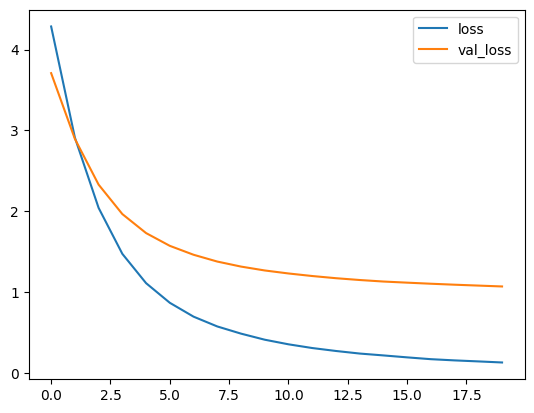

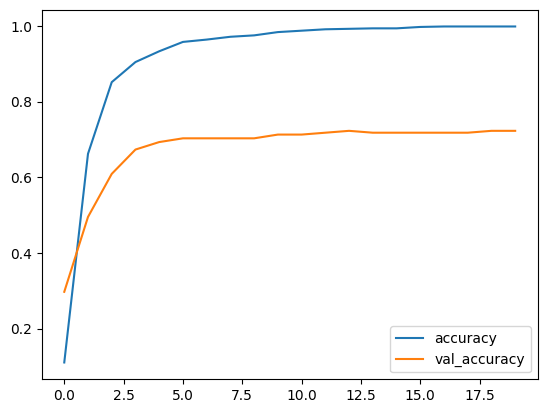

In [16]:
# Plot training history
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

In [17]:
# Evaluate model on validation set
val_loss, val_acc = efficient_net_model.evaluate(valid_ds)
print(f"Validation Loss: {val_loss} Validation Accuracy: {val_acc}")

7/7 [==============================] - 2s 319ms/step - loss: 1.0704 - accuracy: 0.7228
Validation Loss: 1.0703593492507935 Validation Accuracy: 0.7227723002433777


In [18]:
# Plot confusion matrix
val_predictions = np.argmax(efficient_net_model.predict(valid_ds), axis=1)
plot_confusion_matrix(val_targets, val_predictions, CFG.classes)

7/7 [==============================] - 5s 317ms/step


In [19]:
# Test classifying a video from a URL
video_url_to_classify = "https://www.engr.colostate.edu/me/facil/dynamics/files/drop.avi"  
classify_video_url(efficient_net_model, video_url_to_classify)

1/1 [==============================] - 3s 3s/step
Predicted Class: Mixing


'Mixing'

In [23]:
# Save the model
efficient_net_model.save('/kaggle/working/Video_Classification_Model.h5')